# Data Science for Cycling #4 - How to Calculate Route Gradient with Python
- Notebook 4/6
- You'll only need Numpy, Pandas, and Matplotlib to follow along
- Let's import the libraries and tweak Matplotlib's default stylings:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

- Let's read in the dataset
- You'll need the one exported in the previous notebook, as it has elevation and distance data:

In [11]:
route_df = pd.read_csv('../200km_route_df_elevation_distance.csv', parse_dates=['time', 'time_delta'])

route_df['time_delta'] = pd.to_timedelta(route_df['time_delta'])

route_df.head(10)

,latitude,longitude,elevation,time,elevation_diff,latitude_prev,longitude_prev,distance_delta,time_delta,cum_elevation,cum_distance
0,48.089763,11.466253,522.6,2020-07-12 06:26:18+00:00,0.0,0.000000,0.000000,0.0,NaT,0.0,0.0
1,48.089763,11.466253,522.6,2020-07-12 06:26:19+00:00,0.0,48.089763,11.466253,0.0,0 days 00:00:01,0.0,0.0
2,48.089763,11.466253,522.6,2020-07-12 06:26:20+00:00,0.0,48.089763,11.466253,0.0,0 days 00:00:01,0.0,0.0
3,48.089763,11.466253,522.6,2020-07-12 06:26:21+00:00,0.0,48.089763,11.466253,0.0,0 days 00:00:01,0.0,0.0
4,48.089763,11.466253,522.6,2020-07-12 06:26:22+00:00,0.0,48.089763,11.466253,0.0,0 days 00:00:01,0.0,0.0
5,48.089763,11.466253,522.8,2020-07-12 06:26:23+00:00,0.2,48.089763,11.466253,0.0,0 days 00:00:01,0.2,0.0
6,48.089763,11.466253,522.8,2020-07-12 06:26:24+00:00,0.0,48.089763,11.466253,0.0,0 days 00:00:01,0.2,0.0
7,48.089763,11.466253,522.8,2020-07-12 06:26:25+00:00,0.0,48.089763,11.466253,0.0,0 days 00:00:01,0.2,0.0
8,48.089763,11.466253,522.8,2020-07-12 06:26:26+00:00,0.0,48.089763,11.466253,0.0,0 days 00:00:01,0.2,0.0
9,48.089763,11.466253,523.0,2020-07-12 06:26:27+00:00,0.2,48.089763,11.466253,0.0,0 days 00:00:01,0.4,0.0


In [10]:
route_df.dtypes

latitude                      float64
longitude                     float64
elevation                     float64
time              datetime64[ns, UTC]
elevation_diff                float64
latitude_prev                 float64
longitude_prev                float64
distance_delta                float64
time_delta            timedelta64[ns]
cum_elevation                 float64
cum_distance                  float64
dtype: object

<br>

## How to Calculate Gradient from a Strava Route
- A gradient is nothing but a slope of the surface you're riding on
- Our data is quite limited, as we have only 835 data points spread over 36 kilometers, but let's do our best
- We can estimate the average gradient between two data points by dividing the elevation difference between them with the distance covered and multiplying the result with a 100
- Let's test the logic with hardcoded values from the second data point:

- The average grade from the route start (point 1) to the second data point was 2.1%
- It's only the average, so in the 87 meters we could have 15 meters with 10% grade and the remaining 70 meters completely flat, or the entire 87 meters could be on a 2% incline
- The point is - we can't know for sure, so this logic will have to do

- Let's apply it to the entire dataset:
    - We'll skip the first row, as there's nothing to compare it with
    - Gradients are usually rounded to a single decimal points, like 6.1%

In [4]:
# gradients = [np.nan]

# for ind, row in route_df.iterrows(): 
#     if ind == 0:
#         continue
#     grade = (row['elevation_diff'] / row['distance']) * 100
#     gradients.append(np.round(grade, 1))
    
# gradients[:10]

[nan, 2.1, 0.5, -0.0, -0.2, -1.1, 0.8, 1.7, -0.1, -0.5]

In [14]:
route_df['gradient_approx'] = route_df.apply(lambda x: 0 if x['distance_delta']==0 else np.round(100*x['elevation_diff']/x['distance_delta'],2), axis=1)

- Calculations done - we'll now visualize the average gradient for each of the 835 data points
    - X-axis: individual data point
    - Y-axis: average gradient (%)

<AxesSubplot:title={'center':'Median Gradient over time (in %)'}, xlabel='time'>

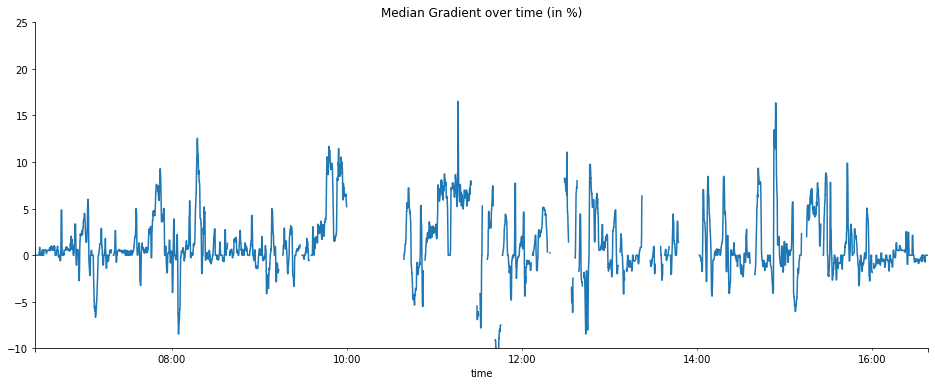

In [33]:
(route_df
 .set_index('time')
 ['gradient_approx']
 .resample('5s')
 .mean()
 .rolling(10)
 .median()
 .plot(ylim=[-10,25], title='Median Gradient over time (in %)')
)

clean raw data:

In [38]:
route_df.loc[~route_df['gradient_approx'].between(-35,35), 'gradient_approx'] = np.nan

- It should look a lot better now:

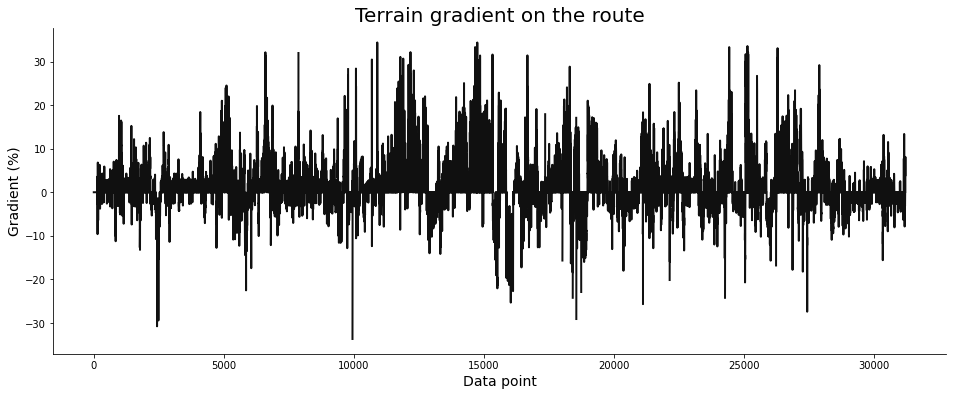

In [39]:
plt.title('Terrain gradient on the route', size=20)
plt.xlabel('Data point', size=14)
plt.ylabel('Gradient (%)', size=14)
route_df['gradient_approx'].plot(lw=2, color='#101010');

- Definitely a step in the right directions, but we now have a couple of missing data points
    - Take a look at the previous chart around X value of 400
- We'll need to interpolate these

<br>

## How to Interpolate Incorrect Gradients From a Strava Route
- First things first, let's assign the calculated gradients to a new column in the dataset:

- And now let's see where the missing values are:

In [40]:
route_df[route_df['gradient_approx'].isna()]

,latitude,longitude,elevation,time,elevation_diff,latitude_prev,longitude_prev,distance_delta,time_delta,cum_elevation,cum_distance,gradient_approx
6595,47.808878,11.566289,623.6,2020-07-12 08:16:53+00:00,0.4,47.808873,11.566276,1.120010,0 days 00:00:01,101.0,45859.667695,NaN
6600,47.808910,11.566357,625.2,2020-07-12 08:16:58+00:00,0.4,47.808905,11.566350,0.763993,0 days 00:00:01,102.6,45865.909775,NaN
7869,47.808293,11.654485,684.8,2020-07-12 08:38:07+00:00,0.4,47.808290,11.654472,1.027702,0 days 00:00:01,162.2,54250.400869,NaN
7870,47.808327,11.654509,686.4,2020-07-12 08:38:48+00:00,1.6,47.808293,11.654485,4.188651,0 days 00:00:41,163.8,54254.589519,NaN
9775,47.723047,11.717102,717.6,2020-07-12 09:10:36+00:00,1.8,47.723065,11.717096,2.053510,0 days 00:00:04,195.0,68245.447798,NaN
9944,47.711908,11.727636,693.6,2020-07-12 09:15:29+00:00,-3.2,47.711927,11.727599,3.486272,0 days 00:00:01,171.0,69854.064456,NaN
11762,47.671210,11.815708,782.8,2020-07-12 09:47:09+00:00,0.6,47.671222,11.815713,1.387418,0 days 00:00:01,260.2,81222.342884,NaN
12166,47.661547,11.824404,860.4,2020-07-12 09:53:53+00:00,0.4,47.661546,11.824396,0.610040,0 days 00:00:01,337.8,82712.261488,NaN
14100,47.645281,11.896587,936.2,2020-07-12 11:04:56+00:00,0.4,47.645272,11.896594,1.131090,0 days 00:00:01,413.6,93818.339691,NaN
14737,47.660010,11.885925,1034.8,2020-07-12 11:15:33+00:00,0.2,47.660008,11.885927,0.268429,0 days 00:00:01,512.2,95865.136691,NaN


- We can ignore the first one, as it's missing because there was no way to calculate it
- Let's focus on the second one and isolate it with the surrounding couple of rows:

In [42]:
route_df.to_csv('../200km_route_df_gradient.csv', index=False)

- In the next notebook, you'll learn how to analyze the gradient profile of a route
- It will give you a deeper insight of distance cycled in different gradient ranges